## EECS 531 - E2 - A4
### Tristan Maidment (tdm47)

#### Goal
The purpose of this exercise is to implement the Lucas Kanade optical flow algorithm.

#### Implementation

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pims import ImageSequence
from numpy.linalg import lstsq
import timeit

To test the optical flow algorithm, we will be testing it on two image sequences.

In [2]:
img_rubic = ImageSequence('./data/rubic/rubic.*.png', as_grey=True)
img_sphere = ImageSequence('./data/sphere/sphere.*.png', as_grey=True)

As part of the exercise, I will be doing the following sub-question in order.

**a)** Compute the discrete derivative components in the motion gradient constraint equation for a single pixel location of a moving image, `I(x,y,t)`.

During this step, the spatial gradient `I_x, I_y` is calculated by taking the difference of the neighboring pixels.  In addition, we estimate temporal gradient, `I_t` by taking the intensity difference between the two time slices.

In [3]:
def gradient_components(img0, img1, x, y):
    height, width = img0.shape
    I_x = np.subtract(img0[x+1, y],img0[x-1,y])/2 if x > 0 and x < width else 0
    I_y = np.subtract(img0[x, y+1],img0[x,y-1])/2 if y > 0 and y < height else 0
    I_t = np.subtract(img1[x,y], img0[x,y]) if y > 0 and y < height and x > 0 and x < width else 0 # I_t approximator
    return I_x, I_y, I_t

In [4]:
I_x, I_y, I_t = gradient_components(img_rubic[0]/255, img_rubic[1]/255, 100, 100)
print("I_x:", I_x, "I_y:", I_y, "I_t:", I_t)

I_x: 0.15490196078431373 I_y: -0.0215686274509804 I_t: -0.02745098039215685


**b)** Compute the matrix **A** and vector **b** representing the motion constraint equations over a (small) *n × n* window centered on pixel `(x, y)`.  

Matrix **A** is of size `n^2 * 2`.  The left column contains a vectorized column of the *x* gradients and the right column contains a vectorized column of the *y* gradients.

Matrix **b** contains a vectorized list of the temporal gradients.

In [5]:
# n = window size
# I will be using a gradient estimator kernel,
# originally used for edge detection to calculate A and B
def compute_Ab(img0, img1, x, y, n):
    A = np.zeros((n**2, 2))
    b = np.zeros(n**2)
    offset = np.floor(n/2); 
    
    for j in np.arange(n):
        for i in np.arange(n):
            I_x, I_y, I_t = gradient_components(img0, img1, int(x + i - offset), int(y + j - offset))
            A[(i*n) + j,0] = I_x
            A[(i*n) + j,1] = I_y
            b[(i*n) + j] = I_t
        
    return A, b

In [6]:
#print(compute_Ab(img_rubic[0]/255, img_rubic[1]/255, 100, 100, 5))

**c)**  Solve the constraint equations either directly using the formula in the lecture slides or using a least- squares solver to estimate motion (u, v) at point (x, y).

Now that we have a vectorized 2D linear representation of the of the data surrounding the point in question, the **d** matrix `(u, v)` contains the motion vector at that point.  We have the equation in the form `A * d = b`

This can be found via least squares regression.

In [7]:
def compute_uv(A, b):
    #print(np.matmul(A.T, A).shape, np.matmul(A.T, -b).shape)
    #uv = linregress(np.matmul(A.T, A).shape, np.matmul(A.T, -b).shape)
    uv = lstsq(np.matmul(A.T, A), -np.matmul(A.T, b), rcond=None)
    return uv[0]

In [8]:
A,b = compute_Ab(img_sphere[0]/255, img_sphere[1]/255, 100, 100, 5)
uv = compute_uv(A, b)
print(uv)

[0.30035571 2.27552987]


**d)** Estimate the motion for an grid of locations covering the image.

Now that we have the ability to get the motion vector at any point, we can simply test the direction of movement at various points around the picture.  Using *matplotlib's* `quiver` functionality, we can create a nice representation of the optical flow.

In [9]:
def optical_flow_field(img0, img1, window_size, grid_size):
    height, width = img1.shape
    
    grid_x, grid_y = grid_size[0], grid_size[1]
    
    flow = np.zeros((grid_x, grid_y, 2))
    delta_x, delta_y = int(height/grid_x), int(width/grid_y)
    
    x = np.arange(0, width, delta_x) + np.floor(delta_x/2)
    y = np.arange(0, height, delta_y) + np.floor(delta_y/2)
    gridX, gridY = np.meshgrid(x,y);
    
    for x in np.arange(0, grid_x):
        for y in np.arange(0, grid_y):
            A,b = compute_Ab(img0, img1, x*delta_x, y*delta_y, window_size)
            uv = compute_uv(A, b)
            flow[x,y,:] = (uv[0], uv[1])
    return (gridX, gridY), flow

In [10]:
grid, flow = optical_flow_field(img_rubic[0]/255, img_rubic[1]/255, 14, (30, 32))

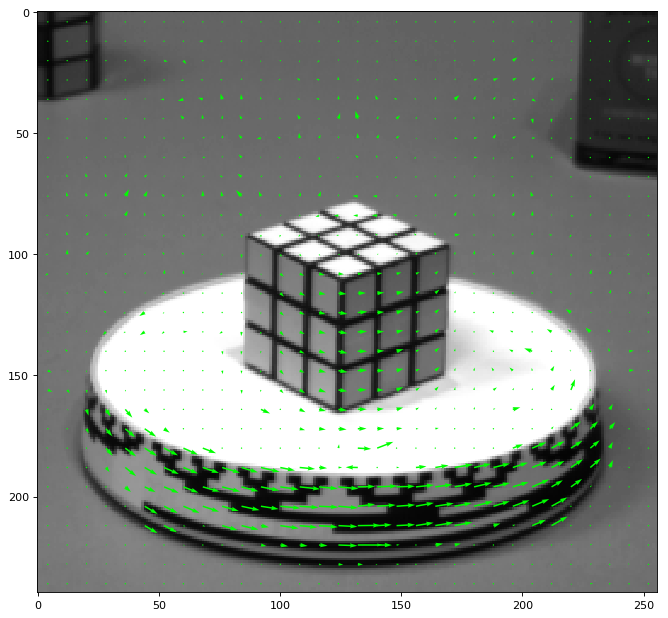

In [11]:
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_rubic[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,1], flow[:,:,0], color='lime', angles="xy",scale=40)
plt.show()

#### Optimization
Due to the order of the steps required by the directions, the calculation of the optical flow via the Lucas-Kanade algorithm is greatly unoptimzied.  For example, the gradient is at each coordinate point is calculated `(n^2)-1` more times that it needs to be.  For this reason, I have implemented an optimized for of this algorithm that avoids that problem, by only calculating the gradient once.

Another optimzation that will be used is the use of gradient estimators.  To estimate the gradient we will be using the *sobel kernel*, which I used for edge detection earlier this year.

In addition, I added the ability to use the singular values of matrix **A** as the coefficient for the motion vector.  This helps with optical flow for certain image sequences, but significantly decreases the optical flow detection for other sequences.

In [12]:
def lucas_kanade_optimzed(img0, img1, window_size, grid_size, svd=False):
    height, width = img0.shape
    
    #sobel kernels
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) * 1/8
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]) * 1/8
    
    grad_y = cv2.filter2D(img0, -1, kernel_x)
    grad_x = cv2.filter2D(img0, -1, kernel_y)
    grad_z = np.subtract(img1, img0)
    
    grid_x, grid_y = grid_size[0], grid_size[1]
    
    flow = np.zeros((grid_x, grid_y, 2))
    delta_x, delta_y = int(height/grid_x), int(width/grid_y)
    
    x = np.arange(0, width, delta_x) + np.floor(delta_x/2)
    y = np.arange(0, height, delta_y) + np.floor(delta_y/2)
    gridX, gridY = np.meshgrid(x,y);
    
    for i in np.arange(0, grid_x):
        for j in np.arange(0, grid_y):
            uv = eval_region(grad_x, grad_y, grad_z, i*delta_x, j*delta_y, window_size, svd)
            flow[i,j,:] = (uv[0], uv[1])
    return (gridX, gridY), flow
    
def eval_region(grad_x, grad_y, grad_z, x, y, n, svd): 
    A = np.zeros((n**2, 2))
    b = np.zeros(n**2)
    offset = np.floor(n/2)
    x_ = int(x - offset)
    y_ = int(y - offset)
    
    for j in np.arange(n):
        for i in np.arange(n):
            A[(i*n) + j,0] = grad_x[x_ + i, y_ + j]
            A[(i*n) + j,1] = grad_y[x_ + i, y_ + j]
            b[(i*n) + j] = grad_z[x_ + i, y_ + j]
    uv = lstsq(np.matmul(A.T, A), -np.matmul(A.T, b), rcond=None)
    return np.multiply(uv[0], uv[3]) if svd else uv[0]

#### Timing Comparison
Using the ore optimized method for this method is significantly faster when processing the optical flow of the images.

In [13]:
%timeit optical_flow_field(img_rubic[0]/255, img_rubic[1]/255, 14, (30, 32))
%timeit lucas_kanade_optimzed(img_rubic[0]/255, img_rubic[1]/255, 14, (30, 32), False)

3.02 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
626 ms ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


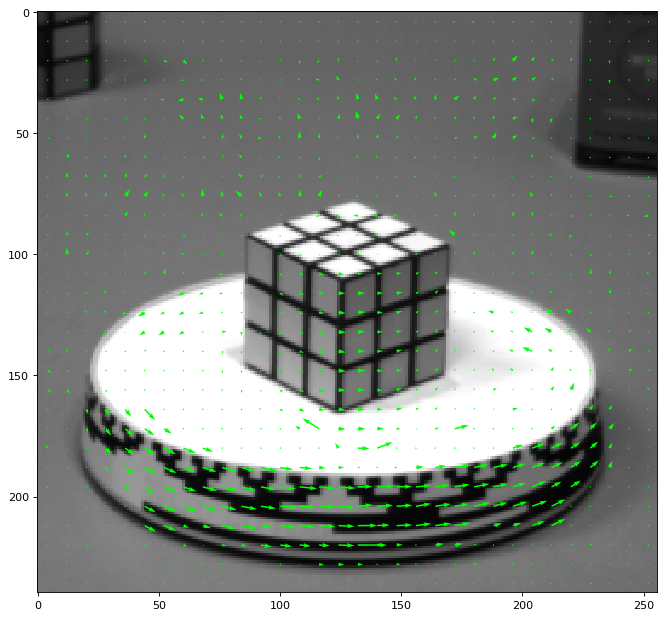

In [14]:
grid, flow = lucas_kanade_optimzed(img_rubic[0]/255, img_rubic[1]/255, 14, (30, 32))
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_rubic[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,1], flow[:,:,0], color='lime', angles="xy",scale=50)
plt.show()

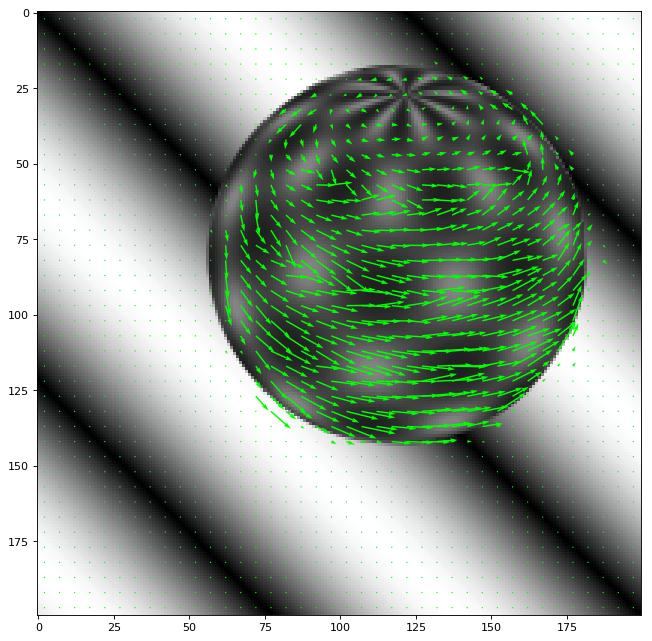

In [15]:
grid, flow = lucas_kanade_optimzed(img_sphere[0]/255, img_sphere[1]/255, 8, (40, 40))
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_sphere[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,1], flow[:,:,0], color='lime', angles="xy",scale=50)
plt.show()

#### Singular Values
By using the Singular Values of matrix **A** as a coefficient for the motion vectors, we can get significantly better detection for the Rubic's cube.  This is due to the fact that the noisy sections (small changes in intensity) will inherently have lower singular values.  

However, due to the lack of noise and small intensity value changes created by the translating gradient patches of the sphere, the singular values are very small along the surface, resulting in incorrectly truncated motion vectors.

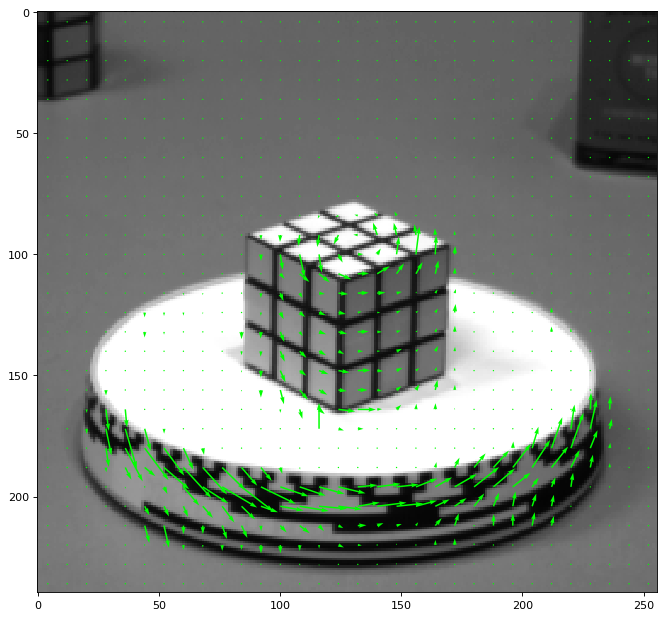

In [16]:
grid, flow = lucas_kanade_optimzed(img_rubic[0]/255, img_rubic[1]/255, 14, (30, 32), True)
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_rubic[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,1], flow[:,:,0], color='lime', angles="xy",scale=25)
plt.show()

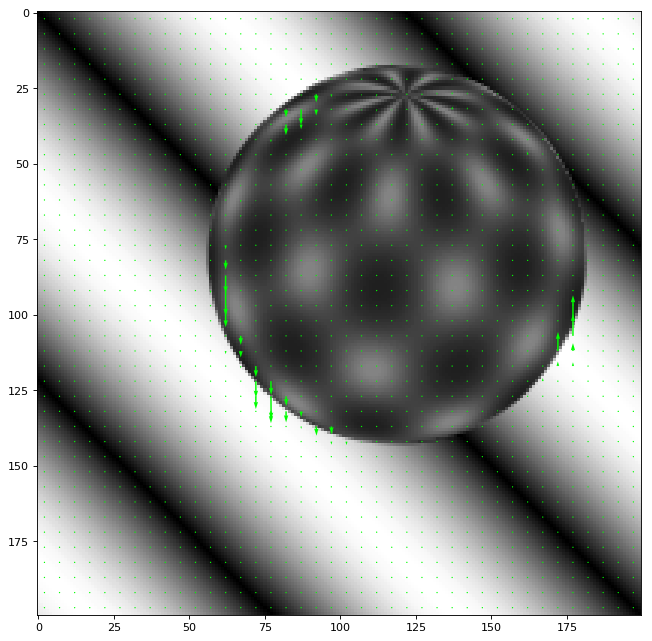

In [17]:
grid, flow = lucas_kanade_optimzed(img_sphere[0]/255, img_sphere[1]/255, 8, (40, 40), True)
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(img_sphere[1], cmap='gray')
plt.quiver(grid[0], grid[1], flow[:,:,1], flow[:,:,0], color='lime', angles="xy",scale=50)
plt.show()

## Conclusion

The Lucas-Kanade Method provides a much more accurate representation of the motion flow by using the gradients of the image to calculate the motion vectors.  This is more robust due to the fact that template matching is vulnerable to noise.  
In addition, much of the motion capture in the images are not translations in the plane of the image.  For instance, in the sphere example, the left side of the sphere is moving towards the viewer and the right side is moving away.  This sort of motion is not a translation, and is not captured well by template matching.